# **Step 1: Extract vertices from the 3D model in Unity**

This is the `Reward.cs` script with some logic that writes out the vertices to a text file.

```c#
using UnityEngine;
using Backend;
using System.Collections.Generic;
using System.Text;
using System.IO;

public class Reward : MonoBehaviour
{
    public ExperimentSO experiment;

    // add vector3 positions to this list to verify they're in the correct location
    private Vector3[] temp = { 
        // new Vector3 { x = 0, y = 2, z = 0 } 
    };

    public void Start()
    {
        experiment.OnNextRound.AddListener(updatePosition); // when 
        updatePosition();

        // spawn temp rewards
        for (int i = 0; i < temp.Length; i++)
        {
            GameObject instance = GameObject.Instantiate(gameObject);
            instance.transform.position = temp[i];
        }

        // VERTICES EXTRACTION 
        var floor = GameObject.Find("FLOOR");
        var floorMesh = floor.GetComponent<MeshFilter>();

        Mesh mesh = floorMesh.sharedMesh;

        Debug.LogFormat("#isReadable = {0}", mesh.isReadable);


        Vector3[] vertices = mesh.vertices;

        string filePath = Application.persistentDataPath + "/vertices.txt";
        Debug.Log(filePath);

        // Write the string to a file
        File.WriteAllText(filePath, FormatVectorList(new List<Vector3>(vertices)));
    }

    public void OnClick()
    {
        experiment.RewardFound();
        experiment.StopRound(); // TODO we don't want to instantly stop the round
    }

    private void updatePosition()
    {
        int phaseNumber = experiment.status.phaseNumber;
        Phase phase = experiment.startExperimentData.phases[phaseNumber];
        var position = phase.arenaPositions.rewardPositions[phase.rewardPositionNumber];
        gameObject.transform.position = new Vector3 { x = position.x, y = position.y, z = position.z }; // TODO replace reward position with the ones in experiment data
    }

    // VERTICES EXTRACTION 
    string FormatVectorList(List<Vector3> vectorList)
    {
        StringBuilder stringBuilder = new StringBuilder();
        stringBuilder.Append("[");

        for (int i = 0; i < vectorList.Count; i++)
        {
            Vector3 vector = vectorList[i];
            stringBuilder.AppendFormat("({0}, {1}, {2})", vector.x, vector.y, vector.z);

            // Add comma for all elements except the last one
            if (i < vectorList.Count - 1)
            {
                stringBuilder.Append(", ");
            }
        }

        stringBuilder.Append("]");
        return stringBuilder.ToString();
    }
}
```

# **Step 2: Analyze the vertices**

In [1]:
# reading the data
with open('./vertices.txt') as f:
    data = f.read()

print(data[:50] + '...]')

# the text is a valid python array so we init an array using `exec`
variables = {}
exec(f'vertices={data}', variables)

points = variables['vertices']
points = [(x, y, z) for (x, y, z) in points]

print(f'#points = {len(points)}, {points[0]}')

[(54.91655, -1, 12.36465), (54.91655, 0, 12.36465)...]
#points = 20022, (54.91655, -1, 12.36465)


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot2d(points, *options):
    x_coords = [point[0] for point in points]
    z_coords = [point[2] for point in points]
    plt.axis('equal')

    for option in options:
        option()
        
    plt.scatter(x=x_coords, y=z_coords)

def plot3d(points):
    # Create a figure and a 3D plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    # Extract x, y, z coordinates from the points
    x_coords, y_coords, z_coords = zip(*points)
    
    # Plot the points
    ax.scatter3D(x_coords, y_coords, z_coords)
    
    # Set labels for each axis
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_box_aspect((1, 1, 1))
    ax.mouse_init()
    
    # Show the plot
    plt.show()

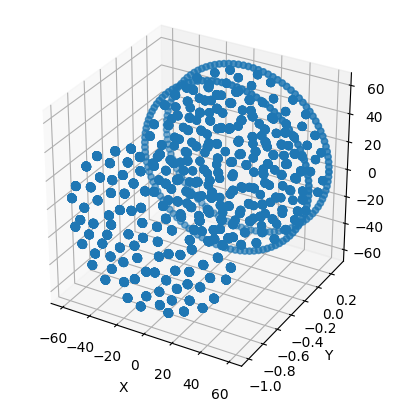

In [3]:
# We can see there are 3 layers
plot3d(points)

In [4]:
points = [(x, y, z) for (x, y, z) in points if y == -1]
print(f'#points = {len(points)}, {points[0]}')

#points = 9800, (54.91655, -1, 12.36465)


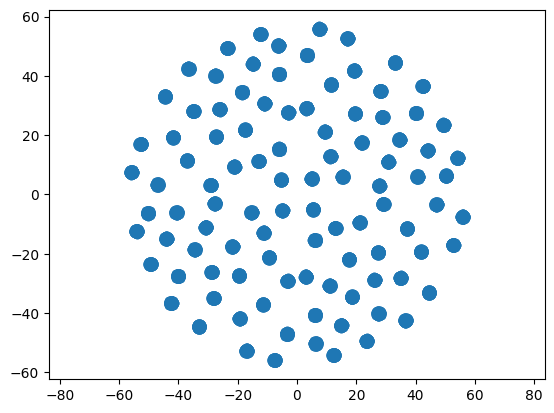

In [5]:
plot2d(points)

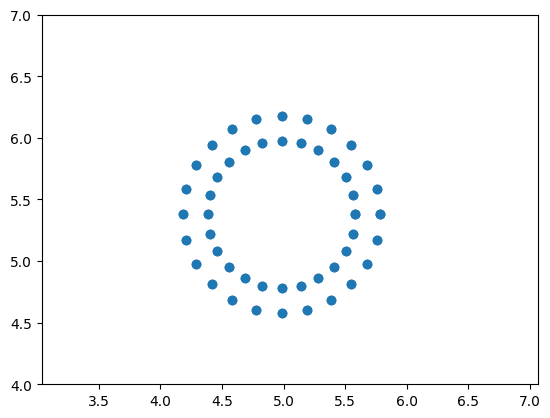

In [6]:
# Each of those clumps from above looks like this
plot2d(points, lambda: plt.xlim(5, 5.1), lambda: plt.ylim(4, 7))

# **Step 3: Cluster the points and average their position to get the center**

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=100, n_init='auto', algorithm='elkan', max_iter=1000)
kmeans.fit(points)

clusters = kmeans.predict(points)

In [8]:
points_by_cluster = []
for _ in range(100):
    points_by_cluster.append([])

for (point, cluster) in zip(points, clusters):
    points_by_cluster[cluster].append(point)

# All 100 clusters have 98 points each == 9800 points total as expected
all([len(point_cluster) == 98 for point_cluster in points_by_cluster])

True

In [9]:
avg_points = []

for point_cluster in points_by_cluster:
    x_avg = round(sum([x for (x, y, z) in point_cluster])/len(point_cluster), 3)
    y_avg = round(sum([y for (x, y, z) in point_cluster])/len(point_cluster), 3)
    z_avg = round(sum([z for (x, y, z) in point_cluster])/len(point_cluster), 3)

    avg_points.append((x_avg, y_avg, z_avg))

print(f'#avg points = {len(avg_points)}')

#avg points = 100


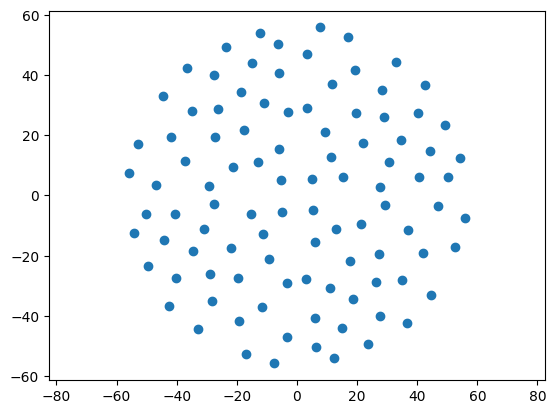

In [10]:
plot2d(avg_points)

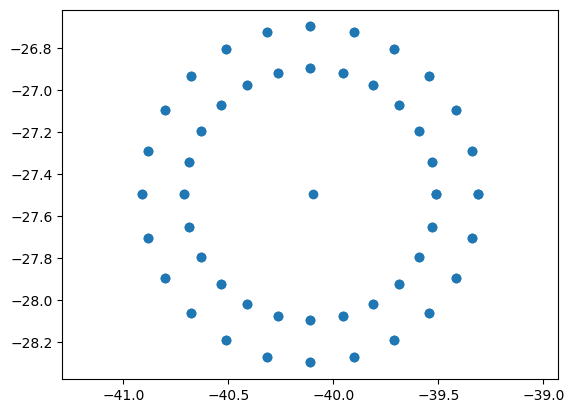

In [11]:
cluster0 = points_by_cluster[0]
plot2d([*cluster0, avg_points[0]])

# **Step 4: Sort the points in a convenient way**

In [12]:
import math

def sort_by_quadrant_and_distance(point):
    x, y, z = point
    
    quadrant = 0
    if x >= 0 and z >= 0:
        quadrant = 0
    elif x < 0 and z >= 0:
        quadrant = 3
    elif x < 0 and z < 0:
        quadrant = 2
    else:  # x >= 0 and z < 0
        quadrant = 1

    
    return (quadrant, math.sqrt(x**2 + z**2))

# Sort the points by their distance from the origin
sorted_points = sorted(avg_points, key=sort_by_quadrant_and_distance)

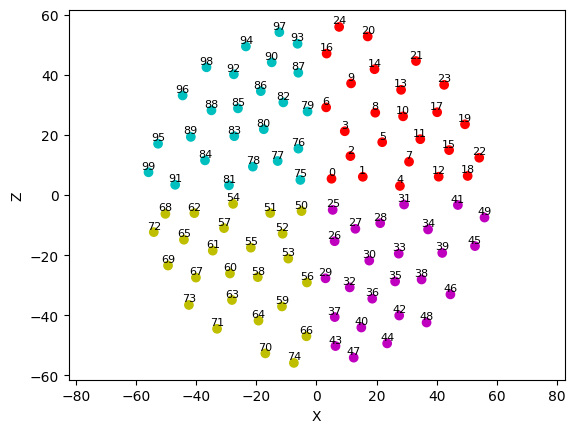

In [13]:
x_coords, _, z_coords = zip(*sorted_points)
colors = ['r']*25 + ['m']*25 + ['y']*25 + ['c']*25

# Create a scatter plot
plt.scatter(x_coords, z_coords, c=colors)

# Set labels for the axes
plt.xlabel('X')
plt.ylabel('Z')

# Add labels to the data points
for i, (x, z) in enumerate(zip(x_coords, z_coords), start=0):
    label = f"{i}"
    plt.annotate(label, (x, z), textcoords="offset points", xytext=(0, 2.5), ha='center', fontsize=8)
                 
# Show the plot
plt.axis('equal')
plt.show()

# **Step 5: Print the points as C# or Go**

In [14]:
depth = 0.7

In [15]:
for (x, y, z) in sorted_points:
    print(f'new Vector3{{x={x}f, y={depth}f, z={z}f}},')

new Vector3{x=4.998f, y=0.7f, z=5.378f},
new Vector3{x=15.405f, y=0.7f, z=6.029f},
new Vector3{x=11.285f, y=0.7f, z=12.915f},
new Vector3{x=9.413f, y=0.7f, z=21.176f},
new Vector3{x=27.751f, y=0.7f, z=2.983f},
new Vector3{x=21.859f, y=0.7f, z=17.541f},
new Vector3{x=3.209f, y=0.7f, z=29.122f},
new Vector3{x=30.78f, y=0.7f, z=11.043f},
new Vector3{x=19.546f, y=0.7f, z=27.344f},
new Vector3{x=11.503f, y=0.7f, z=37.09f},
new Vector3{x=28.798f, y=0.7f, z=26.133f},
new Vector3{x=34.525f, y=0.7f, z=18.533f},
new Vector3{x=40.64f, y=0.7f, z=6.06f},
new Vector3{x=28.137f, y=0.7f, z=34.944f},
new Vector3{x=19.308f, y=0.7f, z=41.806f},
new Vector3{x=44.108f, y=0.7f, z=14.898f},
new Vector3{x=3.371f, y=0.7f, z=47.01f},
new Vector3{x=40.124f, y=0.7f, z=27.495f},
new Vector3{x=50.276f, y=0.7f, z=6.307f},
new Vector3{x=49.395f, y=0.7f, z=23.489f},
new Vector3{x=17.032f, y=0.7f, z=52.702f},
new Vector3{x=33.093f, y=0.7f, z=44.526f},
new Vector3{x=54.131f, y=0.7f, z=12.365f},
new Vector3{x=42.456f, y=

In [16]:
for (x, y, z) in sorted_points:
    print(f'{{X:{x}, Y:{depth}, Z:{z}}},')

{X:4.998, Y:0.7, Z:5.378},
{X:15.405, Y:0.7, Z:6.029},
{X:11.285, Y:0.7, Z:12.915},
{X:9.413, Y:0.7, Z:21.176},
{X:27.751, Y:0.7, Z:2.983},
{X:21.859, Y:0.7, Z:17.541},
{X:3.209, Y:0.7, Z:29.122},
{X:30.78, Y:0.7, Z:11.043},
{X:19.546, Y:0.7, Z:27.344},
{X:11.503, Y:0.7, Z:37.09},
{X:28.798, Y:0.7, Z:26.133},
{X:34.525, Y:0.7, Z:18.533},
{X:40.64, Y:0.7, Z:6.06},
{X:28.137, Y:0.7, Z:34.944},
{X:19.308, Y:0.7, Z:41.806},
{X:44.108, Y:0.7, Z:14.898},
{X:3.371, Y:0.7, Z:47.01},
{X:40.124, Y:0.7, Z:27.495},
{X:50.276, Y:0.7, Z:6.307},
{X:49.395, Y:0.7, Z:23.489},
{X:17.032, Y:0.7, Z:52.702},
{X:33.093, Y:0.7, Z:44.526},
{X:54.131, Y:0.7, Z:12.365},
{X:42.456, Y:0.7, Z:36.596},
{X:7.54, Y:0.7, Z:55.871},
{X:5.393, Y:0.7, Z:-4.983},
{X:6.043, Y:0.7, Z:-15.391},
{X:12.93, Y:0.7, Z:-11.271},
{X:21.19, Y:0.7, Z:-9.398},
{X:2.997, Y:0.7, Z:-27.737},
{X:17.556, Y:0.7, Z:-21.845},
{X:29.136, Y:0.7, Z:-3.194},
{X:11.057, Y:0.7, Z:-30.766},
{X:27.358, Y:0.7, Z:-19.532},
{X:37.104, Y:0.7, Z:-11.488},